# Van der Pol oscillator

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from matplotlib.pyplot import rcParams
from utils import plot_xv

### We first start by looking at state space trajectories to understand the dynamics of the VdP oscillator
https://www.johndcook.com/blog/2019/12/22/van-der-pol/

The vdp oscillator is interesting because it adds a nonlinear damping term, which creates a limit cycle.

Its equation is 
$$\ddot{x} = \mu \dot{x}(1-x^2) - x$$

The (1-x^2) terms makes it so that states between -1 and 1 have "negative" damping, increasing the velocity outwards. This is what creates the limit cycle. We will later build a controller to counteract this force and drive the dynamics to 0.

In [9]:
from scipy.integrate import solve_ivp

In [10]:
def vdp(t, z, mu=1):
    x,v = z
    return [v, mu*(1 - x**2)*v - x]

In [11]:
rcParams['figure.figsize'] = 12, 4
T = np.arange(0,25,0.1)
@interact(mu=FloatSlider(value=1, min=-5, max=5, step=0.5))
def plot_interactive_vdp(mu):
    y = solve_ivp(vdp, y0=[-3,0], t_span=(0,25), t_eval=T, args=(mu,))
    plot_xv(y.y[0], y.y[1], y.t, title='Unforced Dynamics',
           ax1ylim=[-4,4], ax2xlim=[-3,3], ax2ylim=[-4,4])

interactive(children=(FloatSlider(value=1.0, description='mu', max=5.0, min=-5.0, step=0.5), Output()), _dom_c…

### We then introduce controls
The dynamics now become 
$$\ddot{x} = \mu \dot{x}(1-x^2) - x + u$$

In [1]:
import control as ct

In [12]:
def vdp_with_u(t,x,u,params):
    q,p=x
    mu = params.get('mu', 1)
    # not sure why they restrict to positive input
    u = u if u > 0 else 0
    return [p, mu*(1 - q**2)*p - q + u]

In [74]:
vdpio = ct.NonlinearIOSystem(vdp_with_u, states=('q', 'p'), inputs=('u'), outputs=('q', 'p'), name='vdp')

##### We start by visualizing how the dynamics respond to random and constant inputs
Play with the sliders:
- In "random" control_type, $u$ changes the variance $\sigma^2$ of the gaussian random input at each time step
- In "constant" control_type, $u$ is the control input delivered to the system at each time step

In [14]:
X0 = [-3,0]                 # Initial H, L
T = np.arange(0, 50, 0.1)   # Simulation 70 years of time

# Simulate the system with different types of controls
@interact(control_type = ['random', 'constant'], 
          mu = FloatSlider(value=1, min=0, max=5, step=0.5),
          u = FloatSlider(value=1, min=-5, max=5, step=0.25))
def plot_controlled_vdp(control_type, mu, u=1.):
    if control_type == 'random':
        u = np.random.randn(len(T)) * u
    elif control_type == 'constant':
        u = u
    t, y = ct.input_output_response(vdpio, T, u, X0, params={'mu':mu})
    plot_xv(y[0],y[1],t)

interactive(children=(Dropdown(description='control_type', options=('random', 'constant'), value='random'), Fl…

#### We first test a PID controller (see https://python-control.readthedocs.io/en/0.8.3/iosys.html?highlight=predprey#example for example using NonlinearIOSystem functionalities)
##### Can't get the system to converge to (0,0) like this, no matter kp,ki,kd. Is something wrong? (eg. look at comment right below this)

In [92]:
# In order to be able to cascade it with a PID controller, we need the system to only have 1 output.
# So we choose output q+p (we actually output -q-p since not sure how to do proper feedback using the nonlineario library)
vdpio = ct.NonlinearIOSystem(vdp_with_u, outfcn = lambda t,x,u,params: -x[0]-x[1], states=('q', 'p'), inputs=('u'), outputs=('q'), name='vdp')
def get_pid_tf(kp=1, ki=1, kd=1, tau=1):
    s = ct.tf('s')
    pid_tf = kp + ki/s + kd*s/(tau*s+1)
    return pid_tf

T = np.linspace(0, 20, 100)
@interact(kp=(0,10), ki=(0,10), kd=(0,10))
def plot_interactive_pidmdp(kp,ki,kd):
    pid_tf = get_pid_tf(kp,ki,kd)
    pidio = ct.tf2io(pid_tf, outputs=('u'), inputs='e', name='pid')
    vdp_closedio = ct.InterconnectedSystem(
        (vdpio, pidio),
        connections=(("vdp.u", 'pid.u'),
                    ('pid.e', 'vdp.q')),
        inplist=[],
        outlist=('vdp.q', 'pid.u')
    )
    t, y, x = ct.input_output_response(vdp_closedio, T, 0, [1, 1, 0, 0], return_x=True)
    plot_xv(x[0],x[1])

interactive(children=(IntSlider(value=5, description='kp', max=10), IntSlider(value=5, description='ki', max=1…

##### We now test an LQR controller

In [76]:
# We first linearize around (0,0) to build a controller
linvdp = ct.linearize(vdpio, [0,0], 0, params={'mu':1})
K,_,_ = ct.lqr(linvdp, np.diag([1,1]), 0.1)
lqr = ct.StateSpace(0, -K, 1, np.zeros((1,2)))
lqrio = ct.ss2io(lqr, inputs=('q','p'), outputs='u', name='lqr', states=None)
vdpio = ct.NonlinearIOSystem(vdp_with_u, states=('q', 'p'), inputs=('u'), outputs=('q', 'p'), name='vdp')

In [77]:
vdp_closed = ct.InterconnectedSystem(
    (vdpio, lqrio),
    connections=(
        ('vdp.u', 'lqr.u'),
        ('lqr.q', 'vdp.q'),
        ('lqr.p', 'vdp.p')),
    inplist=[],
    outlist=('vdp.q', 'vdp.p', 'lqr.u')
)
print(vdp_closed)

System: (None)
Inputs (0): 
Outputs (3): 
States (3): x[0], x[1], x[2], 


not working... doesn't stay at (0,0) but instead goes back to limit cycle.

TODO: check this... and implement a plot_xvu function

Text(0.5, 1.0, 'controls')

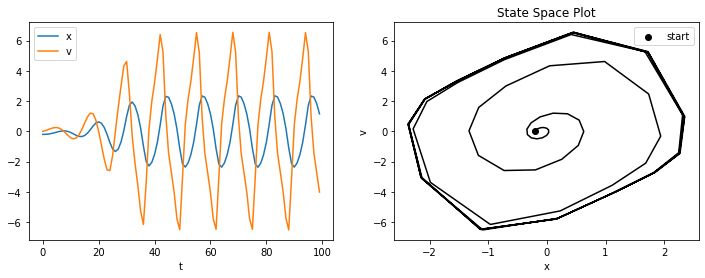

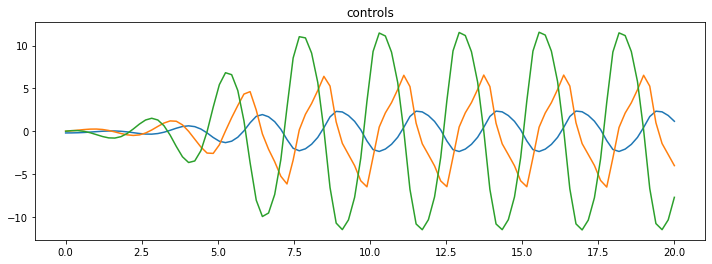

In [27]:
# Simulate the system
T = np.linspace(0, 20, 100)
t, y = ct.input_output_response(vdp_closed, T, 0, [-0.2, 0, 0])

plot_xv(y[0],y[1])
plt.figure()
plt.plot(T, y.T)
plt.title('controls')

### We then test Koopman
Implementation largely inspired from https://github.com/i-abr/mpc-koopman/blob/master/mpc_with_koopman_op.ipynb

In [16]:
import autograd.numpy as np
from autograd import jacobian
from scipy.linalg import logm
import scipy.linalg

In [17]:
class VanDerPol(object):
    def __init__(self, eps=1.0, dt=0.01):
        self.eps = eps
        self.dt = dt
        self.dfdx = jacobian(self.f, argnum=0)
        self.dfdu = jacobian(self.f, argnum=1)
        self.num_states = 2
        self.num_actions = 1
        self.reset()
        # and koopman related stuff
        self.set_obs_odd_deg(1)
        self.koopmanA = None
        self.koopmanB = None
        
    def reset(self):
        self.state = np.random.uniform(-3., 3., 
                                       size=(self.num_states,))
        return self.state.copy() # return a copy
    def sample_action(self):
        return np.random.uniform(-3., 3.,
                                size=(self.num_actions,))
    def f(self, x, u):
        xdot = np.array([
            x[1],
            -x[0] + self.eps * (1 - x[0]**2) * x[1] + u[0]
        ])
        return xdot
    def get_linearization(self, x, u):
        return self.dfdx(x, u), self.dfdu(x, u)
    def step(self, u): ## RK4 step
        k1 = self.f(self.state, u) * self.dt
        k2 = self.f(self.state + k1/2.0, u) * self.dt
        k3 = self.f(self.state + k2/2.0, u) * self.dt
        k4 = self.f(self.state + k3, u) * self.dt
        self.state = self.state + (k1 + 2 * (k2 + k3) + k4)/6
        # self.state = self.state + self.f(self.state, u) * self.dt # euler integration
        return self.state.copy()

    # We also add the koopman related methods here
    def set_obs_odd_deg(self, deg):
        # degree of polynomial observable functions (note we only need odd degrees for vdp!)
        assert deg%2==1, "degree must be odd."
        self.obs_odd_deg = deg
        self.num_x_obs = len(self.z(self.state, self.sample_action())) - self.num_actions
        
    def z(self, x, u, obs_odd_deg=None):
        if obs_odd_deg is None:
            obs_odd_deg = self.obs_odd_deg
        z = list(x)
        for d in range(3,obs_odd_deg+1,2):
            for i in range(d+1):
                z.append(x[0]**i * x[1]**(d-i))
        z += list(u) # important that u is at the end
        return np.array(z)
    
    def get_cont_koopman_operator(self, num_trials=10, horizon=200):
        M = num_trials * horizon ## M sized data

        num_obs = self.num_x_obs + self.num_actions
        A = np.zeros((num_obs, num_obs))
        G = np.zeros((num_obs, num_obs))

        ## loop to collect data
        for k in range(num_trials):
            x_t = self.reset() # reset the state 
            u_t = self.sample_action()
            for t in range(horizon):
                x_tpo = self.step(u_t)
                u_tpo = u_t
                
                A += np.outer(self.z(x_tpo, u_tpo), self.z(x_t, u_t))
                G += np.outer(self.z(x_t, u_t), self.z(x_t, u_t))

                # reset for next loop
                x_t = x_tpo
                u_t = self.sample_action() # linked code above was keeping the same action... not sure why
        A /= M
        G /= M
        koopman_operator = np.dot(A, np.linalg.pinv(G))
        cont_koopman_operator = logm(koopman_operator)/vdp.dt
        self.koopmanA = cont_koopman_operator[:self.num_x_obs,:self.num_x_obs]
        self.koopmanB = cont_koopman_operator[:self.num_x_obs, self.num_x_obs:]
        return self.koopmanA, self.koopmanB
    
    def get_lqr(self, q=1.0, r=1e-2):
        Q = np.zeros((self.num_x_obs, self.num_x_obs))
        Q[0,0] = q
        Q[1,1] = q
        R = np.diag([r]) 
        P = scipy.linalg.solve_continuous_are(self.koopmanA, self.koopmanB, Q, R)
        self.Klqr = np.linalg.inv(R).dot(self.koopmanB.T.dot(P))
        return self.Klqr

    def simulate(self, T=10, X0=None):
        if X0 is None:
            state = self.reset() # reset the state
        else:
            state = X0
        u_def = self.sample_action() # sample the action to get a dummy input
        target_z = self.z(0.*state, u_def)[:self.num_x_obs] # transform the target state into the lifted functions
        horizon = int(T/self.dt)
        trajectory = np.zeros((horizon, vdp.num_states))
        for t in range(horizon):
            trajectory[t,:] = state
            u = -np.dot(self.Klqr, self.z(state, u_def)[:self.num_x_obs] - target_z)
            state = self.step(u)
        return trajectory

In [18]:
vdp = VanDerPol()
@interact(obs_odd_deg=(1,9,2), x0=(-4,4), v0=(-4,4))
def plot_koopman_trajectories(obs_odd_deg,x0,v0):
    vdp.set_obs_odd_deg(obs_odd_deg)
    A,B = vdp.get_cont_koopman_operator()
    Klqr = vdp.get_lqr()
    trajectory = vdp.simulate(X0=np.array([x0,v0]))
    plot_xv(trajectory[:,0], trajectory[:,1])

interactive(children=(IntSlider(value=5, description='obs_odd_deg', max=9, min=1, step=2), IntSlider(value=0, …